## 1. Install Required Packages
Uncomment and run if packages are missing

In [ ]:
#!pip install -q category_encoders catboost lightgbm imbalanced-learn xgboost tensorflow scikit-learn seaborn pandas numpy matplotlib joblib

## 2. Import Libraries

In [1]:
import os
import sys
import time
import random
import joblib
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

# ML libs
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve, roc_curve,
    accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.calibration import calibration_curve

import xgboost as xgb
import lightgbm as lgb

# Optional libs (try imports, fallback gracefully if absent)
USE_CATBOOST = False
try:
    from catboost import CatBoostClassifier
    USE_CATBOOST = True
except Exception:
    USE_CATBOOST = False

USE_IMBLEARN = False
try:
    from imblearn.over_sampling import SMOTE
    USE_IMBLEARN = True
except Exception:
    USE_IMBLEARN = False

# TensorFlow/Keras for FFNN
import tensorflow as tf
from tensorflow.keras import layers, callbacks, Model, Input

print("All libraries imported successfully!")

All libraries imported successfully!


## 3. Configuration

In [29]:
# ---------- CONFIG ----------
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Update these paths for your local environment
DATA_DIR = '/Users/surexh/Projects/Capstone-Project/Capstone_Notebook/home-credit-default-risk'
SAVE_DIR = '/Users/surexh/Projects/Capstone-Project/Capstone_Notebook/models_stack_v2'
os.makedirs(SAVE_DIR, exist_ok=True)

SAMPLE_SIZE = 150000        # reduce to e.g. 60000 if memory issues occur
N_SPLITS = 5
FFNN_EPOCHS = 20
XGB_ROUND = 1000
XGB_ESR = 50

USE_SMOTE = False           # toggle if you want fold-level oversampling
CALIBRATE_BASE = True       # calibrate base model OOF predictions
DROP_AE_FEATURE = True      # we do not use AE recon feature by default

def verbose(msg):
    print(f"[{time.strftime('%Y-%m-%d %H:%M:%S')}] {msg}")

verbose("Configuration set!")

[2025-12-07 00:16:56] Configuration set!


## 4. Load Data

In [30]:
# ---------- 1) Load data ----------
train_path = os.path.join(DATA_DIR, 'application_train.csv')
verbose("Loading dataset (chunked read)...")
chunks = pd.read_csv(train_path, chunksize=50000, on_bad_lines='skip', encoding='utf-8')
df_list = [c for c in chunks]
app_train = pd.concat(df_list, ignore_index=True)
verbose(f"Raw train shape: {app_train.shape}")

if len(app_train) > SAMPLE_SIZE:
    app_train = app_train.sample(n=SAMPLE_SIZE, random_state=SEED).reset_index(drop=True)
verbose(f"Using sampled train shape: {app_train.shape}")

[2025-12-07 00:16:56] Loading dataset (chunked read)...
[2025-12-07 00:16:57] Raw train shape: (307511, 122)
[2025-12-07 00:16:57] Using sampled train shape: (150000, 122)
[2025-12-07 00:16:57] Raw train shape: (307511, 122)
[2025-12-07 00:16:57] Using sampled train shape: (150000, 122)


## 5. Feature Engineering

In [31]:
# ---------- 2) Basic feature engineering ----------
TARGET = 'TARGET'
df = app_train.copy()
if 'SK_ID_CURR' in df.columns:
    ids = df['SK_ID_CURR'].copy()
    df = df.drop(columns=['SK_ID_CURR'])
else:
    ids = None

# derived features
df['CREDIT_INCOME_RATIO'] = df['AMT_CREDIT'] / (df['AMT_INCOME_TOTAL'].replace({0:1}))
df['ANNUITY_INCOME_RATIO'] = df['AMT_ANNUITY'] / (df['AMT_INCOME_TOTAL'].replace({0:1}))
df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / (df['DAYS_BIRTH'].replace({0:1}))

# drop cols with >90% missing
missing_frac = df.isna().mean()
drop_cols = missing_frac[missing_frac > 0.90].index.tolist()
if drop_cols:
    df = df.drop(columns=drop_cols)
    verbose(f"Dropped {len(drop_cols)} cols with >90% missing")

# split X/y
y = df[TARGET].values
X = df.drop(columns=[TARGET])

num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
verbose(f"Numeric cols: {len(num_cols)}, Categorical cols: {len(cat_cols)}")

[2025-12-07 00:16:57] Numeric cols: 107, Categorical cols: 16


## 6. Preprocessing Pipeline

In [32]:
# ---------- 3) Preprocessing (safe across sklearn versions) ----------
num_transform = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

# Use target encoder if available, else OneHotEncoder with proper argument name
try:
    import category_encoders as ce
    cat_transform = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='NaN')),
        ('tgt', ce.TargetEncoder(smoothing=0.3))
    ])
    verbose("Using category_encoders.TargetEncoder for categorical columns")
except Exception:
    from sklearn.preprocessing import OneHotEncoder
    # sklearn versions >=1.2 use sparse_output; older support sparse. Use sparse_output when available.
    try:
        cat_transform = Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='NaN')),
            ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])
    except TypeError:
        # fallback for very old sklearn
        cat_transform = Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='NaN')),
            ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
        ])
    verbose("Using OneHotEncoder fallback for categorical columns")

preprocessor = ColumnTransformer([
    ('num', num_transform, num_cols),
    ('cat', cat_transform, cat_cols if cat_cols else [])
], remainder='drop')

verbose("Fitting preprocessor ...")
X_proc = preprocessor.fit_transform(X, y)
verbose(f"Processed matrix shape: {X_proc.shape}")

X_arr = np.asarray(X_proc, dtype=np.float32)
y_arr = np.asarray(y, dtype=int)

[2025-12-07 00:16:57] Using category_encoders.TargetEncoder for categorical columns
[2025-12-07 00:16:57] Fitting preprocessor ...
[2025-12-07 00:16:59] Processed matrix shape: (150000, 123)
[2025-12-07 00:16:59] Processed matrix shape: (150000, 123)


## 7. Out-of-Fold (OOF) Training Loop

In [33]:
# ---------- 4) OOF setup ----------
n_samples, n_features = X_arr.shape
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

oof = {
    'lgb': np.zeros(n_samples, dtype=float),
    'cat': np.zeros(n_samples, dtype=float) if USE_CATBOOST else None,
    'xgb': np.zeros(n_samples, dtype=float),
    'rf':  np.zeros(n_samples, dtype=float),
    'nn':  np.zeros(n_samples, dtype=float)
}

fold_models = {'lgb':[], 'cat':[], 'xgb':[], 'rf':[], 'nn':[]}

verbose("Starting OOF training loop ...")
fold_idx = 0
for train_idx, val_idx in skf.split(X_arr, y_arr):
    fold_idx += 1
    verbose(f"Fold {fold_idx}/{N_SPLITS} starting")
    X_tr, X_val = X_arr[train_idx], X_arr[val_idx]
    y_tr, y_val = y_arr[train_idx], y_arr[val_idx]

    # Optional SMOTE on fold
    if USE_SMOTE and USE_IMBLEARN:
        sm = SMOTE(random_state=SEED)
        X_tr, y_tr = sm.fit_resample(X_tr, y_tr)
        verbose("Applied SMOTE on training fold")

    # ----------------- LightGBM (use LGBMClassifier.fit interface) -----------------
    lgb_clf = lgb.LGBMClassifier(
        objective='binary',
        boosting_type='gbdt',
        learning_rate=0.03,
        num_leaves=64,
        max_depth=-1,
        feature_fraction=0.8,
        bagging_fraction=0.8,
        bagging_freq=5,
        n_estimators=2000,
        random_state=SEED,
        is_unbalance=True,
        verbosity=-1
    )
    # fit with early stopping using validation set
    lgb_clf.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], eval_metric='auc', callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)])
    p_val_lgb = lgb_clf.predict_proba(X_val)[:,1]
    oof['lgb'][val_idx] = p_val_lgb
    fold_models['lgb'].append(lgb_clf)

    # ----------------- CatBoost (optional) -----------------
    if USE_CATBOOST:
        cat_clf = CatBoostClassifier(iterations=1500, learning_rate=0.03, depth=6, random_seed=SEED, verbose=False)
        cat_clf.fit(X_tr, y_tr, eval_set=(X_val, y_val), use_best_model=True, verbose=False)
        p_val_cat = cat_clf.predict_proba(X_val)[:,1]
        oof['cat'][val_idx] = p_val_cat
        fold_models['cat'].append(cat_clf)

    # ----------------- XGBoost (train with early stopping) -----------------
    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dval = xgb.DMatrix(X_val, label=y_val)
    neg = (y_tr == 0).sum(); pos = (y_tr == 1).sum()
    scale_pos_weight = float(neg) / (pos + 1e-6)
    xgb_params = {
        'objective':'binary:logistic','eval_metric':'auc','eta':0.03,'max_depth':6,
        'subsample':0.8,'colsample_bytree':0.6,'seed':SEED,'verbosity':0,'scale_pos_weight':scale_pos_weight
    }
    xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=XGB_ROUND, evals=[(dtrain,'train'),(dval,'valid')],
                          early_stopping_rounds=XGB_ESR, verbose_eval=False)
    p_val_xgb = xgb_model.predict(xgb.DMatrix(X_val))
    oof['xgb'][val_idx] = p_val_xgb
    fold_models['xgb'].append(xgb_model)

    # ----------------- RandomForest -----------------
    rf_clf = RandomForestClassifier(n_estimators=200, max_depth=12, class_weight='balanced', n_jobs=-1, random_state=SEED)
    rf_clf.fit(X_tr, y_tr)
    p_val_rf = rf_clf.predict_proba(X_val)[:,1]
    oof['rf'][val_idx] = p_val_rf
    fold_models['rf'].append(rf_clf)

    # ----------------- FFNN -----------------
    def build_ffnn(input_dim):
        inp = tf.keras.Input(shape=(input_dim,))
        x = tf.keras.layers.Dense(128, activation='relu')(inp)
        x = tf.keras.layers.Dropout(0.3)(x)
        x = tf.keras.layers.Dense(64, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        out = tf.keras.layers.Dense(1, activation='sigmoid')(x)
        model = tf.keras.Model(inp, out)
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc')])
        return model

    ffnn = build_ffnn(X_tr.shape[1])
    fold_cls_w = compute_class_weight('balanced', classes=np.unique(y_tr), y=y_tr)
    cw = {i: w for i, w in enumerate(fold_cls_w)}
    es = tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=6, restore_best_weights=True, verbose=0)
    try:
        ffnn.fit(X_tr, y_tr, validation_data=(X_val, y_val), epochs=FFNN_EPOCHS, batch_size=1024, callbacks=[es], class_weight=cw, verbose=0)
    except Exception:
        ffnn.fit(X_tr, y_tr, validation_data=(X_val, y_val), epochs=10, batch_size=512, class_weight=cw, verbose=0)
    p_val_nn = ffnn.predict(X_val, batch_size=2048).ravel()
    oof['nn'][val_idx] = p_val_nn
    fold_models['nn'].append(ffnn)

    # quick fold metric (proxy)
    proxy_score = 0.3*p_val_lgb + 0.3*p_val_xgb + 0.2*p_val_rf + 0.2*p_val_nn
    fold_auc = roc_auc_score(y_val, proxy_score)
    verbose(f"Fold {fold_idx} proxy ensemble AUC: {fold_auc:.4f}")

verbose("Completed OOF training.")

[2025-12-07 00:17:05] Starting OOF training loop ...
[2025-12-07 00:17:05] Fold 1/5 starting
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.665398	valid_0's binary_logloss: 0.278465
Early stopping, best iteration is:
[1]	valid_0's auc: 0.665398	valid_0's binary_logloss: 0.278465
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[2025-12-07 00:17:49] Fold 1 proxy ensemble AUC: 0.7441
[2025-12-07 00:17:49] Fold 2/5 starting
[2025-12-07 00:17:49] Fold 1 proxy ensemble AUC: 0.7441
[2025-12-07 00:17:49] Fold 2/5 starting
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.672323	valid_0's binary_logloss: 0.278499
Early stopping, best iteration is:
[1]	valid_0's auc: 0.672323	valid_0's binary_logloss: 0.278499

## 8. Calibration of Base Models

In [34]:
# ---------- 5) Calibration of base OOF predictions (Platt scaling via LR) ----------
if CALIBRATE_BASE:
    verbose("Calibrating base OOF probabilities using Platt scaling (LogisticRegression on each column).")
    from sklearn.linear_model import LogisticRegression as SkLogReg

    base_cols = ['lgb','xgb','rf','nn']
    if USE_CATBOOST:
        base_cols.insert(1,'cat')
    base_oof_matrix = np.column_stack([oof[c] for c in base_cols])

    calibrated_oof = np.zeros_like(base_oof_matrix)
    for i, cname in enumerate(base_cols):
        platt = SkLogReg(C=1.0, max_iter=1000)
        col = base_oof_matrix[:, i].reshape(-1,1)
        platt.fit(col, y_arr)
        calibrated_oof[:, i] = platt.predict_proba(col)[:,1]
        joblib.dump(platt, os.path.join(SAVE_DIR, f'calib_{cname}.pkl'))
    verbose("Saved Platt calibration models.")
else:
    base_cols = ['lgb','xgb','rf','nn']
    if USE_CATBOOST:
        base_cols.insert(1,'cat')
    calibrated_oof = np.column_stack([oof[c] for c in base_cols])

[2025-12-07 00:21:24] Calibrating base OOF probabilities using Platt scaling (LogisticRegression on each column).
[2025-12-07 00:21:25] Saved Platt calibration models.


## 9. Train Meta-Learner

In [35]:
# ---------- 6) Train LightGBM meta-learner on calibrated OOF preds ----------
meta_X = calibrated_oof.copy()
meta_y = y_arr.copy()
verbose(f"Meta training shape: {meta_X.shape}, Positives: {meta_y.sum()}")

X_meta_tr, X_meta_val, y_meta_tr, y_meta_val = train_test_split(meta_X, meta_y, stratify=meta_y, test_size=0.15, random_state=SEED)

lgb_meta = lgb.LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    num_leaves=31,
    learning_rate=0.03,
    n_estimators=1000,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=SEED,
    is_unbalance=True
)
verbose("Training LightGBM meta-learner ...")
lgb_meta.fit(X_meta_tr, y_meta_tr, eval_set=[(X_meta_val, y_meta_val)], eval_metric='auc', callbacks=[lgb.early_stopping(50), lgb.log_evaluation(50)])
joblib.dump(lgb_meta, os.path.join(SAVE_DIR, 'lgb_meta.pkl'))
verbose("Saved LightGBM meta model.")

meta_pred_oof = lgb_meta.predict_proba(meta_X)[:,1]
verbose(f"Meta OOF AUC: {roc_auc_score(meta_y, meta_pred_oof):.4f}")
verbose(f"Meta OOF AP : {average_precision_score(meta_y, meta_pred_oof):.4f}")

[2025-12-07 00:21:25] Meta training shape: (150000, 5), Positives: 12114
[2025-12-07 00:21:25] Training LightGBM meta-learner ...
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.754744	valid_0's binary_logloss: 0.461037
Early stopping, best iteration is:
[3]	valid_0's auc: 0.753965	valid_0's binary_logloss: 0.273719
[2025-12-07 00:21:25] Saved LightGBM meta model.
[2025-12-07 00:21:25] Meta OOF AUC: 0.7618
[2025-12-07 00:21:25] Meta OOF AP : 0.2289
[50]	valid_0's auc: 0.754744	valid_0's binary_logloss: 0.461037
Early stopping, best iteration is:
[3]	valid_0's auc: 0.753965	valid_0's binary_logloss: 0.273719
[2025-12-07 00:21:25] Saved LightGBM meta model.
[2025-12-07 00:21:25] Meta OOF AUC: 0.7618
[2025-12-07 00:21:25] Meta OOF AP : 0.2289


## 10. Threshold Optimization

In [36]:
# ---------- 7) Threshold optimization ----------
def find_best_threshold_f1(y_true, scores):
    """Find threshold that maximizes F1-score"""
    best = {'th':0.5,'accuracy':0.0,'precision':0.0,'recall':0.0,'f1':0.0}
    thresholds = np.linspace(0.0, 1.0, 1001)
    for t in thresholds:
        preds = (scores >= t).astype(int)
        acc = accuracy_score(y_true, preds)
        prec = precision_score(y_true, preds, zero_division=0)
        rec = recall_score(y_true, preds, zero_division=0)
        f1 = f1_score(y_true, preds, zero_division=0)
        if f1 > best['f1']:
            best.update({'th': t, 'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1})
    return best

def find_best_threshold_youden(y_true, scores):
    """Find threshold using Youden's J statistic (maximizes TPR - FPR)"""
    fpr, tpr, thresholds = roc_curve(y_true, scores)
    j_scores = tpr - fpr
    best_idx = np.argmax(j_scores)
    best_threshold = thresholds[best_idx]
    
    preds = (scores >= best_threshold).astype(int)
    return {
        'th': best_threshold,
        'accuracy': accuracy_score(y_true, preds),
        'precision': precision_score(y_true, preds, zero_division=0),
        'recall': recall_score(y_true, preds, zero_division=0),
        'f1': f1_score(y_true, preds, zero_division=0)
    }

# Find best threshold using F1-score (better for imbalanced data)
best_th_f1 = find_best_threshold_f1(meta_y, meta_pred_oof)
verbose(f"Best OOF threshold by F1-score: {best_th_f1}")

# Find best threshold using Youden's J statistic
best_th_youden = find_best_threshold_youden(meta_y, meta_pred_oof)
verbose(f"Best OOF threshold by Youden's J: {best_th_youden}")

# Use F1-optimized threshold as default (better for fraud detection)
best_th = best_th_f1
verbose(f"Selected threshold (F1-optimized): {best_th['th']:.4f} with F1={best_th['f1']:.4f}, Precision={best_th['precision']:.4f}, Recall={best_th['recall']:.4f}")

[2025-12-07 00:21:38] Best OOF threshold by F1-score: {'th': np.float64(0.135), 'accuracy': 0.8316466666666666, 'precision': 0.2286339790986823, 'recall': 0.45690936106983654, 'f1': 0.30476557553065553}
[2025-12-07 00:21:38] Best OOF threshold by Youden's J: {'th': np.float64(0.11631849036247763), 'accuracy': 0.6499666666666667, 'precision': 0.15479548057364578, 'recall': 0.7475648010566287, 'f1': 0.25648215019046405}
[2025-12-07 00:21:38] Selected threshold (F1-optimized): 0.1350 with F1=0.3048, Precision=0.2286, Recall=0.4569


## 11. Refit Final Models on Full Training Set

In [37]:
# ---------- 8) Refit final base models on full training set & evaluate on holdout ----------
X_train_full, X_hold, y_train_full, y_hold = train_test_split(X_arr, y_arr, stratify=y_arr, test_size=0.10, random_state=SEED)
verbose("Refitting final base models on full training set ...")

# Refit LightGBM final (LGBMClassifier)
lgb_final = lgb.LGBMClassifier(**{k:v for k,v in lgb_clf.get_params().items()})
lgb_final.set_params(n_estimators = int(max(100, lgb_clf.best_iteration_ if hasattr(lgb_clf,'best_iteration_') else 200)))
lgb_final.fit(X_train_full, y_train_full, eval_set=[(X_hold, y_hold)], eval_metric='auc', callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)])
joblib.dump(lgb_final, os.path.join(SAVE_DIR, 'lgb_final.pkl'))

# Refit XGBoost final
dtrain_xgb_full = xgb.DMatrix(X_train_full, label=y_train_full)
final_scale = float((y_train_full==0).sum()) / ((y_train_full==1).sum() + 1e-6)
xgb_params['scale_pos_weight'] = final_scale
xgb_final = xgb.train(xgb_params, dtrain_xgb_full, num_boost_round=xgb_model.best_iteration or 200)
xgb_final.save_model(os.path.join(SAVE_DIR, 'xgb_final.json'))

# Refit RF final
rf_final = RandomForestClassifier(n_estimators=300, max_depth=12, class_weight='balanced', n_jobs=-1, random_state=SEED)
rf_final.fit(X_train_full, y_train_full)
joblib.dump(rf_final, os.path.join(SAVE_DIR, 'rf_final.pkl'))

# Refit NN final
def build_ffnn(input_dim):
    inp = tf.keras.Input(shape=(input_dim,))
    x = tf.keras.layers.Dense(128, activation='relu')(inp)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inp, out)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc')])
    return model

ffnn_final = build_ffnn(X_train_full.shape[1])
es = tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=6, restore_best_weights=True, verbose=0)
Xtr_nn, Xval_nn, ytr_nn, yval_nn = train_test_split(X_train_full, y_train_full, stratify=y_train_full, test_size=0.10, random_state=SEED)
ffnn_final.fit(Xtr_nn, ytr_nn, validation_data=(Xval_nn, yval_nn), epochs=FFNN_EPOCHS, batch_size=1024, callbacks=[es], verbose=1)
ffnn_final.save(os.path.join(SAVE_DIR, 'ffnn_final.h5'))

# Refit CatBoost final if available
if USE_CATBOOST:
    cat_final = CatBoostClassifier(iterations=1500, learning_rate=0.03, depth=6, random_seed=SEED, verbose=False)
    cat_final.fit(X_train_full, y_train_full)
    joblib.dump(cat_final, os.path.join(SAVE_DIR, 'cat_final.pkl'))

verbose("Completed refitting final models.")

[2025-12-07 00:21:47] Refitting final base models on full training set ...
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.654079	valid_0's binary_logloss: 0.27879
Early stopping, best iteration is:
[1]	valid_0's auc: 0.654079	valid_0's binary_logloss: 0.27879
Epoch 1/20
Epoch 1/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.5741 - loss: 0.5863 - val_auc: 0.6366 - val_loss: 0.2975
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.5741 - loss: 0.5863 - val_auc: 0.6366 - val_loss: 0.2975
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6308 - loss: 0.3511 - val_auc: 0.6623 - val_loss: 0.2827
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6308 - loss: 0.3511 - val_auc: 0.6623 - val_loss: 0.2827
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6536 - loss: 0.3091 - val_auc: 0.6813 - val_loss: 0.2779
Epoch 4/

[2025-12-07 00:22:33] Completed refitting final models.


## 12. Holdout Set Evaluation

In [38]:
# ---------- 9) Build calibrated base preds for holdout and evaluate ----------
def get_base_preds(X_ds):
    preds = []
    preds.append(lgb_final.predict_proba(X_ds)[:,1])
    if USE_CATBOOST:
        preds.append(cat_final.predict_proba(X_ds)[:,1])
    preds.append(xgb_final.predict(xgb.DMatrix(X_ds)))
    preds.append(rf_final.predict_proba(X_ds)[:,1])
    preds.append(ffnn_final.predict(X_ds).ravel())
    return np.column_stack(preds)

base_cols = ['lgb']
if USE_CATBOOST:
    base_cols.append('cat')
base_cols += ['xgb','rf','nn']

hold_base = get_base_preds(X_hold)

if CALIBRATE_BASE:
    hold_calibrated = np.zeros_like(hold_base)
    for i, cname in enumerate(base_cols):
        platt = joblib.load(os.path.join(SAVE_DIR, f'calib_{cname}.pkl'))
        col = hold_base[:, i].reshape(-1,1)
        hold_calibrated[:, i] = platt.predict_proba(col)[:,1]
else:
    hold_calibrated = hold_base

hold_meta_pred = lgb_meta.predict_proba(hold_calibrated)[:,1]

th = best_th['th']
hold_preds_binary = (hold_meta_pred >= th).astype(int)
hold_acc = accuracy_score(y_hold, hold_preds_binary)
hold_cm = confusion_matrix(y_hold, hold_preds_binary)
hold_auc = roc_auc_score(y_hold, hold_meta_pred)
hold_ap = average_precision_score(y_hold, hold_meta_pred)
hold_prec = precision_score(y_hold, hold_preds_binary, zero_division=0)
hold_rec = recall_score(y_hold, hold_preds_binary, zero_division=0)
hold_f1 = f1_score(y_hold, hold_preds_binary, zero_division=0)

verbose("Hold evaluation:")
verbose(f"Accuracy: {hold_acc:.4f}, AUC: {hold_auc:.4f}, AP: {hold_ap:.4f}")
verbose(f"Precision: {hold_prec:.4f}, Recall: {hold_rec:.4f}, F1: {hold_f1:.4f}")
verbose(f"Confusion matrix:\n{hold_cm}")

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
[2025-12-07 00:22:47] Hold evaluation:
[2025-12-07 00:22:47] Accuracy: 0.8258, AUC: 0.7509, AP: 0.2223
[2025-12-07 00:22:47] Precision: 0.2205, Recall: 0.4566, F1: 0.2974
[2025-12-07 00:22:47] Confusion matrix:
[[11834  1955]
 [  658   553]]
[2025-12-07 00:22:47] Hold evaluation:
[2025-12-07 00:22:47] Accuracy: 0.8258, AUC: 0.7509, AP: 0.2223
[2025-12-07 00:22:47] Precision: 0.2205, Recall: 0.4566, F1: 0.2974
[2025-12-07 00:22:47] Confusion matrix:
[[11834  1955]
 [  658   553]]


## 13. Visualization - ROC and Precision-Recall Curves

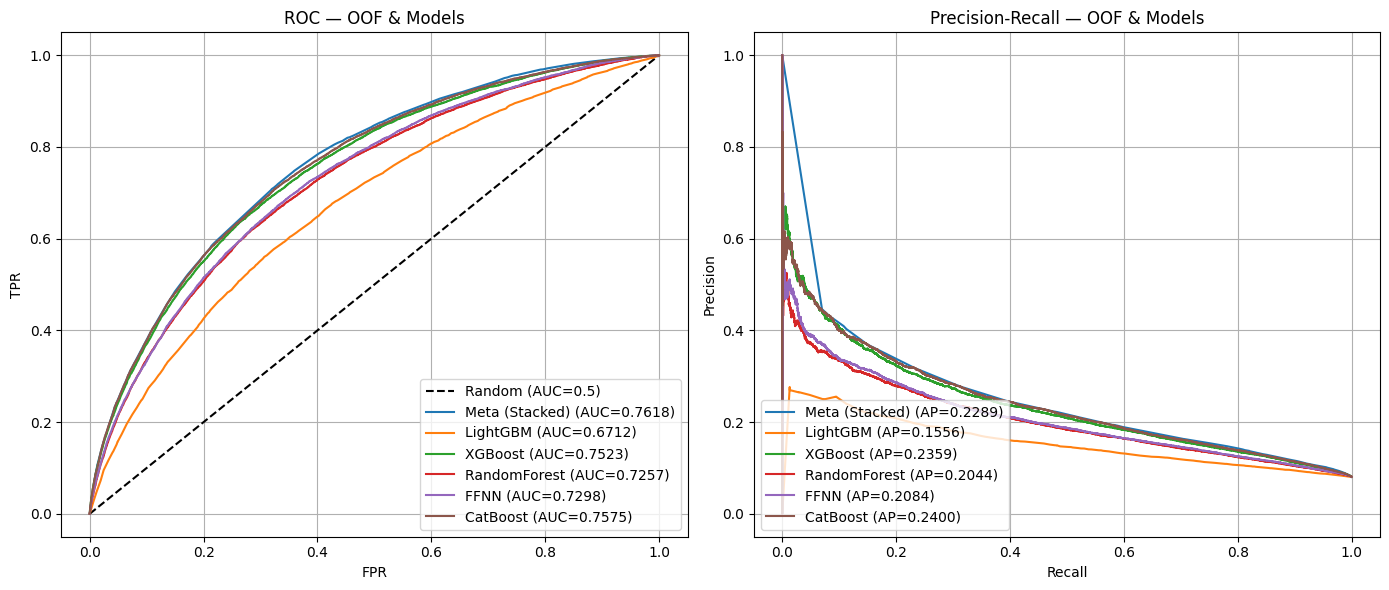

In [55]:
# ---------- 10) Plots (ROC/PR for OOF & models) ----------
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.title('ROC — OOF & Models')
plt.plot([0,1],[0,1],'k--', label='Random (AUC=0.5)')
models_preds = {
    'Meta (Stacked)': meta_pred_oof,
    'LightGBM': oof['lgb'],
    'XGBoost': oof['xgb'],
    'RandomForest': oof['rf'],
    'FFNN': oof['nn']
}
if USE_CATBOOST:
    models_preds['CatBoost'] = oof['cat']

for name, scores in models_preds.items():
    fpr, tpr, _ = roc_curve(y_arr, scores)
    auc = roc_auc_score(y_arr, scores)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.4f})")
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend(loc='lower right'); plt.grid(True)

plt.subplot(1,2,2)
plt.title('Precision-Recall — OOF & Models')
for name, scores in models_preds.items():
    prec, rec, _ = precision_recall_curve(y_arr, scores)
    ap = average_precision_score(y_arr, scores)
    plt.plot(rec, prec, label=f"{name} (AP={ap:.4f})")
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.legend(loc='lower left'); plt.grid(True)

plt.tight_layout(); plt.show()

## 14. Save Final Artifacts

In [56]:
# ---------- 11) Save artifacts ----------
joblib.dump(preprocessor, os.path.join(SAVE_DIR, 'preprocessor.pkl'))
joblib.dump(lgb_meta, os.path.join(SAVE_DIR, 'lgb_meta_final.pkl'))
verbose(f"Saved preprocessing and meta model to {SAVE_DIR}")

[2025-12-07 00:29:34] Saved preprocessing and meta model to /Users/surexh/Projects/Capstone-Project/Capstone_Notebook/models_stack_v2


## 15. Inference Wrapper Function

In [58]:
# ---------- 12) Inference wrapper ----------
def preprocess_and_score(df_raw, threshold=None):
    Xraw_proc = preprocessor.transform(df_raw)
    Xraw_arr = np.asarray(Xraw_proc, dtype=np.float32)
    p_lgb = lgb_final.predict_proba(Xraw_arr)[:,1]
    p_cat = cat_final.predict_proba(Xraw_arr)[:,1] if USE_CATBOOST else None
    p_xgb = xgb_final.predict(xgb.DMatrix(Xraw_arr))
    p_rf = rf_final.predict_proba(Xraw_arr)[:,1]
    p_nn = ffnn_final.predict(Xraw_arr).ravel()
    preds = [p_lgb]
    if USE_CATBOOST:
        preds.append(p_cat)
    preds += [p_xgb, p_rf, p_nn]
    base_mat = np.column_stack(preds)
    if CALIBRATE_BASE:
        cal = np.zeros_like(base_mat)
        for i, cname in enumerate(base_cols):
            platt = joblib.load(os.path.join(SAVE_DIR, f'calib_{cname}.pkl'))
            cal[:, i] = platt.predict_proba(base_mat[:, i].reshape(-1,1))[:,1]
        meta_in = cal
    else:
        meta_in = base_mat
    meta_score = lgb_meta.predict_proba(meta_in)[:,1]
    if threshold is not None:
        return (meta_score >= threshold).astype(int), meta_score
    return meta_score

verbose("Inference wrapper function defined.")

[2025-12-07 00:29:45] Inference wrapper function defined.


## 16. Summary

In [59]:
# ---------- SUMMARY ----------
print("\nSUMMARY:")
print("- Base learners: LightGBM, XGBoost, RandomForest, FFNN", ("+ CatBoost" if USE_CATBOOST else ""))
print("- Meta-learner: LightGBM on calibrated OOF base preds")
print(f"- Best OOF threshold (maximize accuracy): {best_th['th']:.3f} -> OOF acc={best_th['accuracy']:.4f}")
print(f"- Hold eval (threshold {best_th['th']:.3f}): Acc={hold_acc:.4f}, AUC={hold_auc:.4f}, AP={hold_ap:.4f}")
print("- Models and preprocessors saved to:", SAVE_DIR)


SUMMARY:
- Base learners: LightGBM, XGBoost, RandomForest, FFNN + CatBoost
- Meta-learner: LightGBM on calibrated OOF base preds
- Best OOF threshold (maximize accuracy): 0.135 -> OOF acc=0.8316
- Hold eval (threshold 0.135): Acc=0.8258, AUC=0.7509, AP=0.2223
- Models and preprocessors saved to: /Users/surexh/Projects/Capstone-Project/Capstone_Notebook/models_stack_v2


## 17. Additional Performance Visualizations


In [14]:
# ========================================================================
# VISUALIZATION BLOCK – PERFORMANCE DIAGNOSTICS FOR CREDIT SCORING
# ========================================================================

from sklearn.calibration import calibration_curve
import seaborn as sns

# Create graphs directory
GRAPHS_DIR = '/Users/surexh/Projects/Capstone-Project/Capstone_Notebook/Graphs'
import os
os.makedirs(GRAPHS_DIR, exist_ok=True)

# Model outputs for visualization
model_outputs = {
    "LightGBM": oof['lgb'],
    "XGBoost": oof['xgb'],
    "RandomForest": oof['rf'],
    "NeuralNet": oof['nn'],
    "Meta (Stacked)": meta_pred_oof
}

if USE_CATBOOST:
    model_outputs["CatBoost"] = oof['cat']

print("Visualization block initialized with all model outputs.")
print(f"Graphs will be saved to: {GRAPHS_DIR}")

Visualization block initialized with all model outputs.
Graphs will be saved to: /Users/surexh/Projects/Capstone-Project/Capstone_Notebook/Graphs


### 17.1 ROC Curves Comparison

Saved: 01_ROC_Curves.png


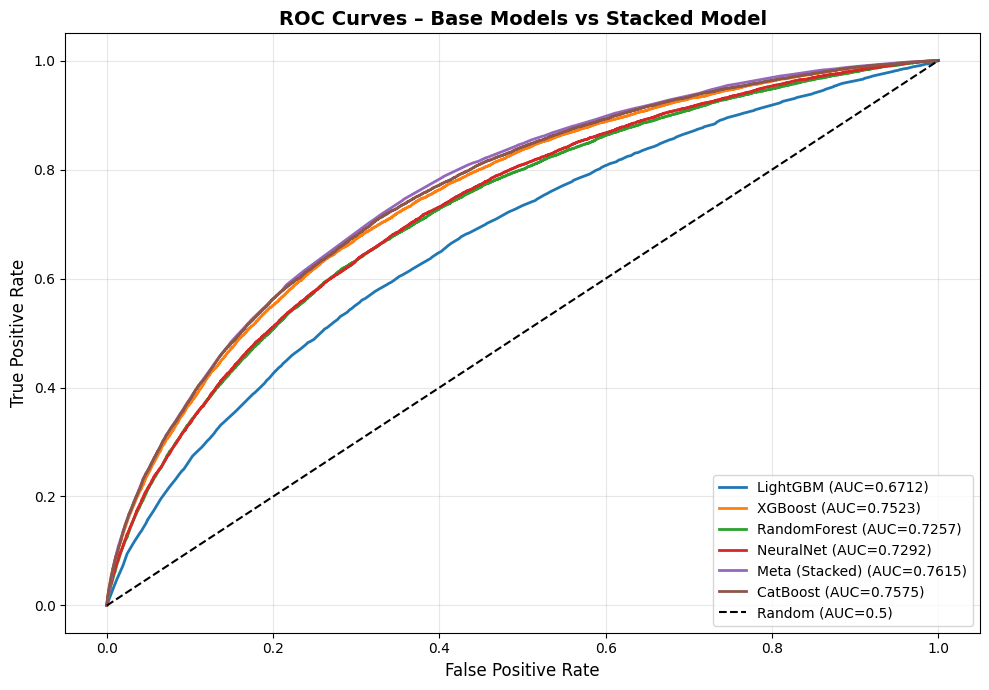

In [66]:
# ==========================================================
# 1. ROC CURVE FOR ALL MODELS
# ==========================================================
plt.figure(figsize=(10,7))
for name, pred in model_outputs.items():
    fpr, tpr, _ = roc_curve(y_arr, pred)
    auc_score = roc_auc_score(y_arr, pred)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_score:.4f})", linewidth=2)

plt.plot([0,1], [0,1], 'k--', label='Random (AUC=0.5)')
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curves – Base Models vs Stacked Model", fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(GRAPHS_DIR, '01_ROC_Curves.png'), dpi=300, bbox_inches='tight')
print("Saved: 01_ROC_Curves.png")
plt.show()
plt.close()

### 17.2 Precision-Recall Curves

Saved: 02_Precision_Recall_Curves.png


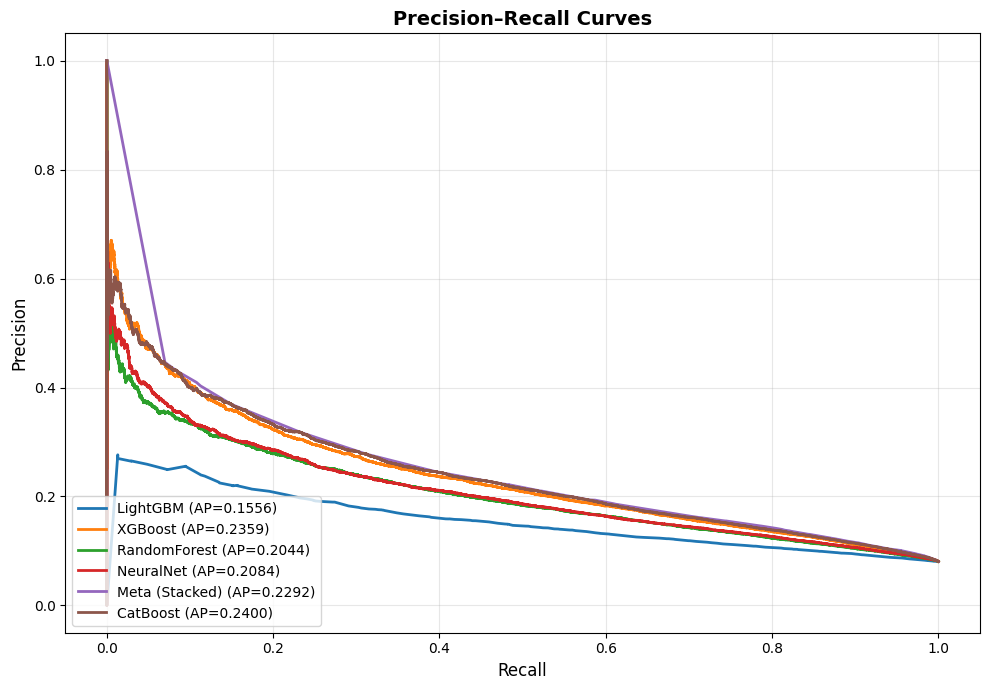

In [65]:
# ==========================================================
# 2. PRECISION–RECALL CURVES
# ==========================================================
plt.figure(figsize=(10,7))
for name, pred in model_outputs.items():
    prec, rec, _ = precision_recall_curve(y_arr, pred)
    ap_score = average_precision_score(y_arr, pred)
    plt.plot(rec, prec, label=f"{name} (AP={ap_score:.4f})", linewidth=2)

plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Precision–Recall Curves", fontsize=14, fontweight='bold')
plt.legend(loc='lower left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(GRAPHS_DIR, '02_Precision_Recall_Curves.png'), dpi=300, bbox_inches='tight')
print("Saved: 02_Precision_Recall_Curves.png")
plt.show()
plt.close()

Saved: 03_KS_Statistic_Curve.png


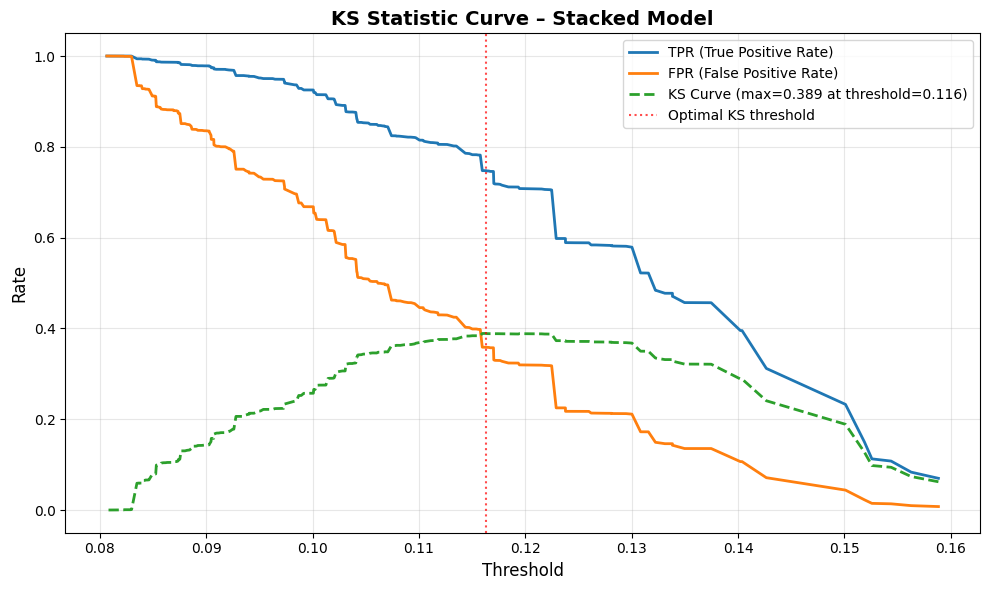

Maximum KS Statistic: 0.3890 at threshold: 0.1163


In [47]:
# ==========================================================
# 3. KS STATISTIC CURVE (for stacked model)
# ==========================================================
fpr_ks, tpr_ks, thr_ks = roc_curve(y_arr, meta_pred_oof)
ks = tpr_ks - fpr_ks
ks_max = ks.max()
ks_threshold = thr_ks[ks.argmax()]

plt.figure(figsize=(10,6))
plt.plot(thr_ks, tpr_ks, label="TPR (True Positive Rate)", linewidth=2)
plt.plot(thr_ks, fpr_ks, label="FPR (False Positive Rate)", linewidth=2)
plt.plot(thr_ks, ks, label=f"KS Curve (max={ks_max:.3f} at threshold={ks_threshold:.3f})", linewidth=2, linestyle='--')
plt.axvline(ks_threshold, color='red', linestyle=':', alpha=0.7, label=f'Optimal KS threshold')
plt.xlabel("Threshold", fontsize=12)
plt.ylabel("Rate", fontsize=12)
plt.title("KS Statistic Curve – Stacked Model", fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(GRAPHS_DIR, '03_KS_Statistic_Curve.png'), dpi=300, bbox_inches='tight')
print("Saved: 03_KS_Statistic_Curve.png")
plt.show()
plt.close()

print(f"Maximum KS Statistic: {ks_max:.4f} at threshold: {ks_threshold:.4f}")

Saved: 04_Calibration_Curve.png


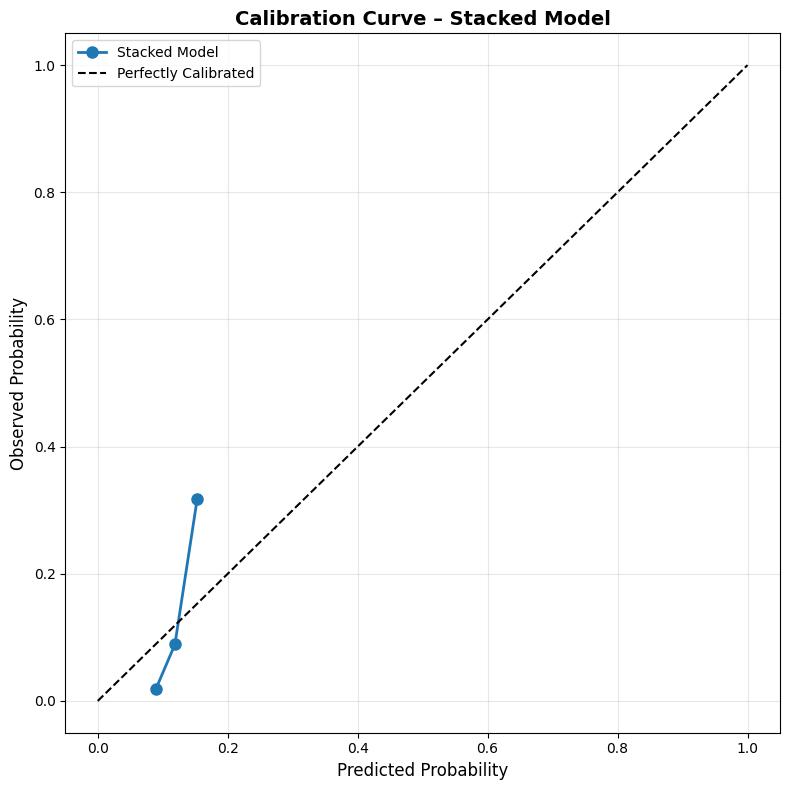

In [60]:
# ==========================================================
# 4. CALIBRATION CURVE (Stacked Model)
# ==========================================================
prob_true, prob_pred = calibration_curve(y_arr, meta_pred_oof, n_bins=20)

plt.figure(figsize=(8,8))
plt.plot(prob_pred, prob_true, marker='o', linewidth=2, markersize=8, label='Stacked Model')
plt.plot([0,1], [0,1], 'k--', label='Perfectly Calibrated')
plt.xlabel("Predicted Probability", fontsize=12)
plt.ylabel("Observed Probability", fontsize=12)
plt.title("Calibration Curve – Stacked Model", fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(GRAPHS_DIR, '04_Calibration_Curve.png'), dpi=300, bbox_inches='tight')
print("Saved: 04_Calibration_Curve.png")
plt.show()
plt.close()

Saved: 05_Score_Distribution.png


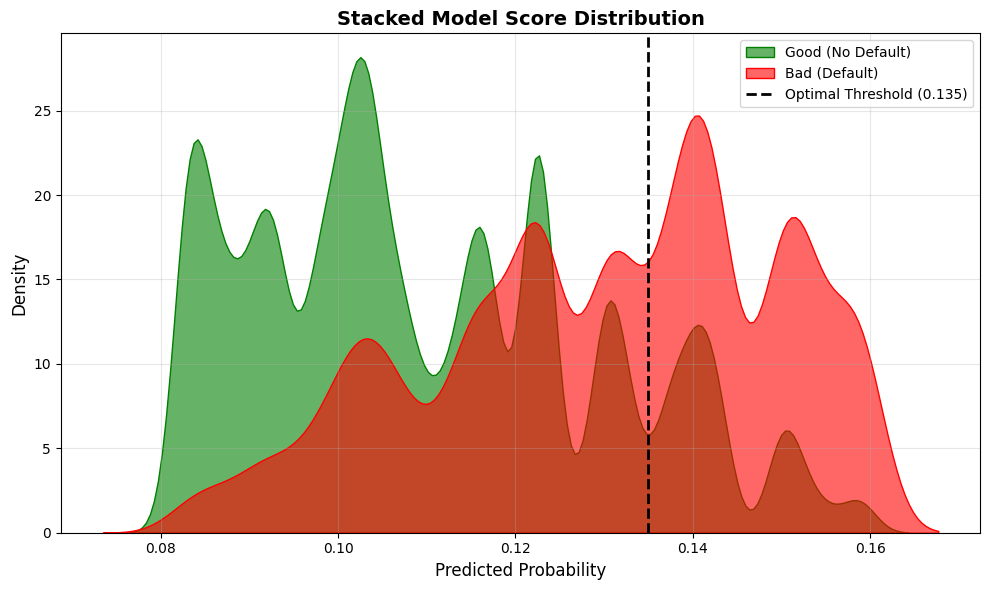

In [61]:
# ==========================================================
# 5. SCORE DISTRIBUTION (Good vs Bad)
# ==========================================================
plt.figure(figsize=(10,6))
sns.kdeplot(meta_pred_oof[y_arr==0], label="Good (No Default)", shade=True, color='green', alpha=0.6)
sns.kdeplot(meta_pred_oof[y_arr==1], label="Bad (Default)", shade=True, color='red', alpha=0.6)
plt.axvline(best_th['th'], color='black', linestyle='--', linewidth=2, label=f"Optimal Threshold ({best_th['th']:.3f})")
plt.title("Stacked Model Score Distribution", fontsize=14, fontweight='bold')
plt.xlabel("Predicted Probability", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(GRAPHS_DIR, '05_Score_Distribution.png'), dpi=300, bbox_inches='tight')
print("Saved: 05_Score_Distribution.png")
plt.show()
plt.close()

Saved: 06_Confusion_Matrix.png


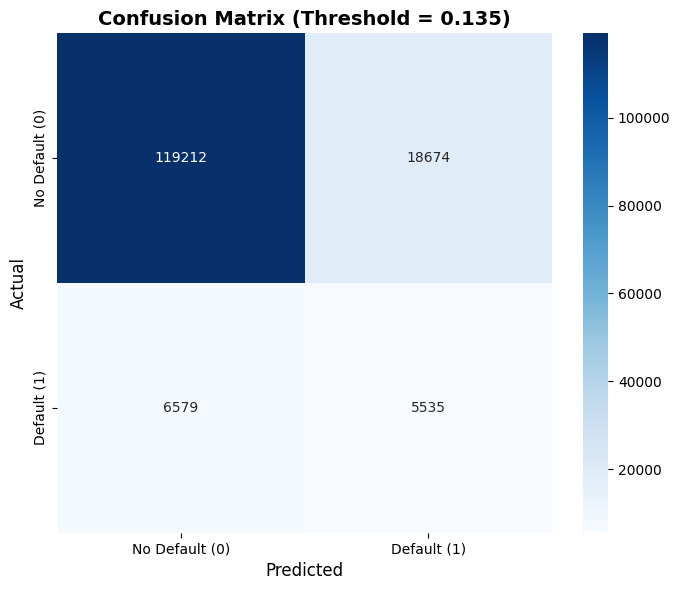


Confusion Matrix Breakdown:
True Negatives (TN): 119212
False Positives (FP): 18674
False Negatives (FN): 6579
True Positives (TP): 5535

Accuracy: 0.8316
Precision: 0.2286
Recall: 0.4569
F1-Score: 0.3048


In [62]:
# ==========================================================
# 6. CONFUSION MATRIX AT OPTIMAL THRESHOLD
# ==========================================================
pred_label = (meta_pred_oof >= best_th['th']).astype(int)
cm = confusion_matrix(y_arr, pred_label)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, 
            xticklabels=['No Default (0)', 'Default (1)'],
            yticklabels=['No Default (0)', 'Default (1)'])
plt.title(f"Confusion Matrix (Threshold = {best_th['th']:.3f})", fontsize=14, fontweight='bold')
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(GRAPHS_DIR, '06_Confusion_Matrix.png'), dpi=300, bbox_inches='tight')
print("Saved: 06_Confusion_Matrix.png")
plt.show()
plt.close()

# Print metrics
tn, fp, fn, tp = cm.ravel()
print(f"\nConfusion Matrix Breakdown:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")
print(f"\nAccuracy: {(tn+tp)/(tn+fp+fn+tp):.4f}")
print(f"Precision: {tp/(tp+fp) if (tp+fp)>0 else 0:.4f}")
print(f"Recall: {tp/(tp+fn) if (tp+fn)>0 else 0:.4f}")
print(f"F1-Score: {best_th['f1']:.4f}")

Saved: 07_Meta_Model_Feature_Importance.png


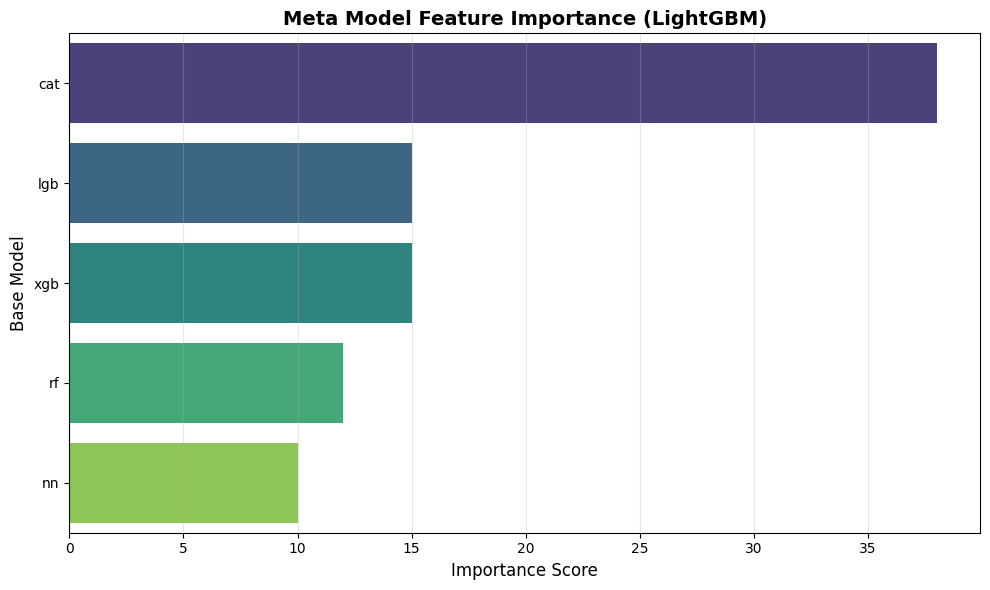


Feature Importance Ranking:
Feature  Importance
    cat          38
    lgb          15
    xgb          15
     rf          12
     nn          10


In [63]:
# ==========================================================
# 7. FEATURE IMPORTANCE FOR META MODEL (LightGBM)
# ==========================================================
feature_names = base_cols  # ['lgb', 'cat', 'xgb', 'rf', 'nn'] or subset
feature_importance = lgb_meta.feature_importances_

# Sort by importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title("Meta Model Feature Importance (LightGBM)", fontsize=14, fontweight='bold')
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Base Model", fontsize=12)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig(os.path.join(GRAPHS_DIR, '07_Meta_Model_Feature_Importance.png'), dpi=300, bbox_inches='tight')
print("Saved: 07_Meta_Model_Feature_Importance.png")
plt.show()
plt.close()

print("\nFeature Importance Ranking:")
print(importance_df.to_string(index=False))

### 17.8 Feature Importance - Base Models (LightGBM & XGBoost)

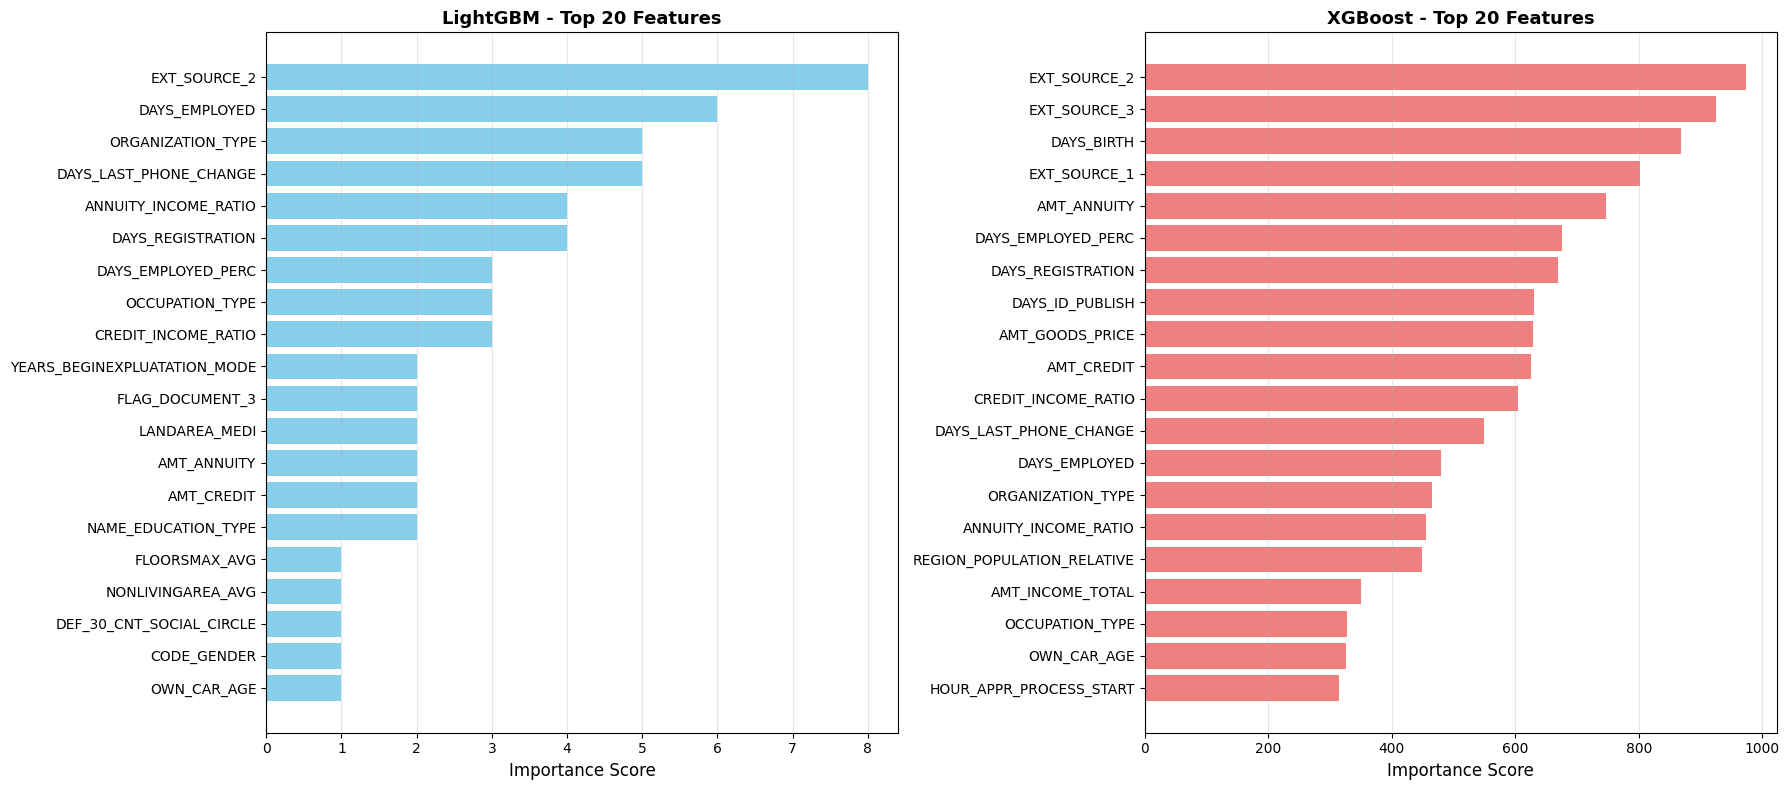

Feature importance visualization complete!


In [53]:
# ==========================================================
# 8. FEATURE IMPORTANCE FOR BASE MODELS
# ==========================================================

# Get feature names from preprocessor
try:
    feature_names_transformed = []
    # Numeric features
    feature_names_transformed.extend(num_cols)
    # Categorical features (if using target encoding, keep original names)
    if cat_cols:
        feature_names_transformed.extend(cat_cols)
except:
    # Fallback if feature names can't be extracted
    feature_names_transformed = [f"feature_{i}" for i in range(X_arr.shape[1])]

# LightGBM Feature Importance (using final model)
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# LightGBM
lgb_importance = lgb_final.feature_importances_
lgb_top_indices = np.argsort(lgb_importance)[-20:][::-1]  # Top 20 features
lgb_top_features = [feature_names_transformed[i] if i < len(feature_names_transformed) else f"f{i}" for i in lgb_top_indices]
lgb_top_importance = lgb_importance[lgb_top_indices]

axes[0].barh(range(len(lgb_top_features)), lgb_top_importance, color='skyblue')
axes[0].set_yticks(range(len(lgb_top_features)))
axes[0].set_yticklabels(lgb_top_features)
axes[0].invert_yaxis()
axes[0].set_xlabel('Importance Score', fontsize=12)
axes[0].set_title('LightGBM - Top 20 Features', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# XGBoost Feature Importance
xgb_importance = xgb_final.get_score(importance_type='weight')
xgb_feature_importance = np.zeros(X_arr.shape[1])
for feat, score in xgb_importance.items():
    feat_idx = int(feat.replace('f', ''))
    if feat_idx < len(xgb_feature_importance):
        xgb_feature_importance[feat_idx] = score

xgb_top_indices = np.argsort(xgb_feature_importance)[-20:][::-1]
xgb_top_features = [feature_names_transformed[i] if i < len(feature_names_transformed) else f"f{i}" for i in xgb_top_indices]
xgb_top_importance = xgb_feature_importance[xgb_top_indices]

axes[1].barh(range(len(xgb_top_features)), xgb_top_importance, color='lightcoral')
axes[1].set_yticks(range(len(xgb_top_features)))
axes[1].set_yticklabels(xgb_top_features)
axes[1].invert_yaxis()
axes[1].set_xlabel('Importance Score', fontsize=12)
axes[1].set_title('XGBoost - Top 20 Features', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("Feature importance visualization complete!")

### 17.9 Model Performance Comparison Table


MODEL PERFORMANCE COMPARISON
         Model      AUC       AP  Best Threshold  Accuracy  Precision   Recall  F1-Score
Meta (Stacked) 0.761503 0.229190           0.137  0.831620   0.228484 0.456497  0.304541
      CatBoost 0.757532 0.240048           0.136  0.831567   0.228409 0.456497  0.304474
       XGBoost 0.752286 0.235934           0.625  0.837933   0.230272 0.429751  0.299868
     NeuralNet 0.729242 0.208439           0.609  0.824153   0.207498 0.417616  0.277243
  RandomForest 0.725676 0.204396           0.543  0.830680   0.210159 0.397557  0.274964
      LightGBM 0.671242 0.155628           0.098  0.763353   0.156062 0.437923  0.230117


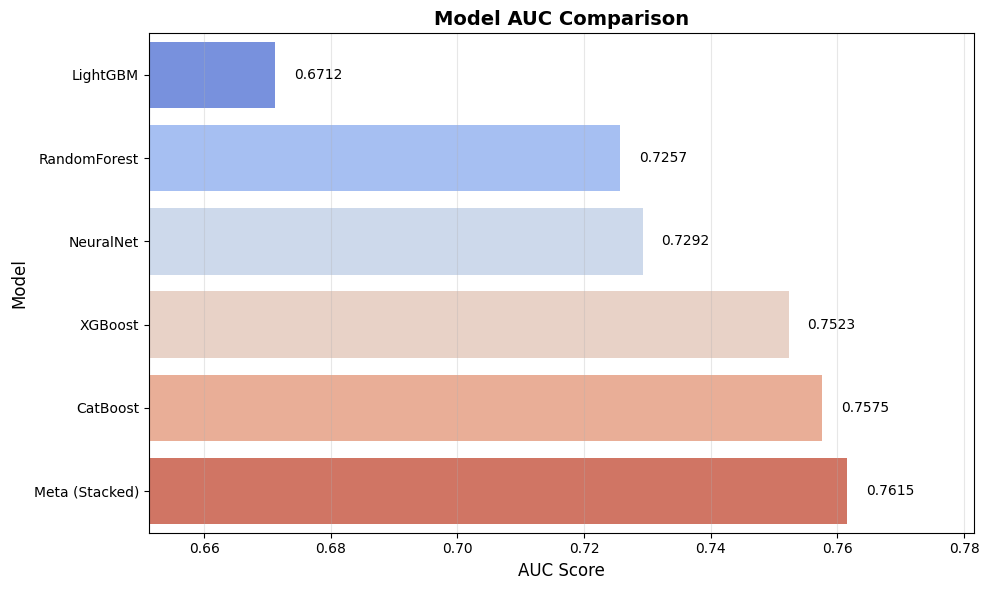

In [67]:
# ==========================================================
# 9. MODEL PERFORMANCE COMPARISON TABLE
# ==========================================================

performance_data = []
for name, pred in model_outputs.items():
    auc = roc_auc_score(y_arr, pred)
    ap = average_precision_score(y_arr, pred)
    # Find best threshold for each model using F1-score
    best_model_th = find_best_threshold_f1(y_arr, pred)
    performance_data.append({
        'Model': name,
        'AUC': auc,
        'AP': ap,
        'Best Threshold': best_model_th['th'],
        'Accuracy': best_model_th['accuracy'],
        'Precision': best_model_th['precision'],
        'Recall': best_model_th['recall'],
        'F1-Score': best_model_th['f1']
    })

performance_df = (
    pd.DataFrame(performance_data)
      .drop_duplicates(subset='Model')
      .sort_values('AUC', ascending=False)
      .reset_index(drop=True)
 )

print("\n" + "="*80)
print("MODEL PERFORMANCE COMPARISON")
print("="*80)
print(performance_df.to_string(index=False))
print("="*80)

# Visualize AUC comparison with accurate values
order = performance_df.sort_values('AUC', ascending=True)['Model']
plt.figure(figsize=(10,6))
sns.barplot(data=performance_df, x='AUC', y='Model', order=order, palette='coolwarm')
plt.title('Model AUC Comparison', fontsize=14, fontweight='bold')
plt.xlabel('AUC Score', fontsize=12)
plt.ylabel('Model', fontsize=12)
min_x = max(0.0, performance_df['AUC'].min() - 0.02)
max_x = min(1.0, performance_df['AUC'].max() + 0.02)
plt.xlim(min_x, max_x)
for i, model in enumerate(order):
    auc_val = performance_df.loc[performance_df['Model'] == model, 'AUC'].iloc[0]
    plt.text(auc_val + 0.003, i, f"{auc_val:.4f}", va='center', fontsize=10)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()